In [ ]:
## Topic Modeling on foreign policies


In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.decomposition import LatentDirichletAllocation, NMF

import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english", ignore_stopwords=True)

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet


#from sklearn.utils import *


In [3]:
# gensim import
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# from gensim.utils import simple_preprocess
# from gensim.parsing.preprocessing import STOPWORDS

In [4]:
{
    "tags": [
        "hide-input",
    ]
}

# let's create our own stopwords library, removing the most frequent AV terms as well
stopwords_AV = [
                # we removed all the quastionning indicators (who, when...) and negation from stopwords
                'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll",
                "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 
                'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
                'themselves',  'this', 'that', "that'll", 'these', 'those', 'am', 
                'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
                'did', 'doing', 'a', 'an', 'the', 'and', 'or', 'of',
                'at', 'by', 'for', 'with',  'into', 'through', 'during', 
                'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 
                 'here', 'there', 'all', 'any', 
                'both' , 'more', 'other', 'such', 'own', 
                'same', 'so', 'than', 'too', 'very', 's', 't', 'just', 
                 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',  'ma',
                # context words -- will be kept for more context
                # 'driving', 'self', 'vehicles', 'autonomous', 'car', 'driverless'
               ]
       

In [5]:
{
    "tags": [
        "hide-input",
    ]
}

# data cleaning functions

# WORDNET LEMMATIZER (with appropriate pos tags)

lemmatizer = WordNetLemmatizer()

# Define function to lemmatize each word with its POS tag

# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
	if nltk_tag.startswith('J'):
		return wordnet.ADJ
	elif nltk_tag.startswith('V'):
		return wordnet.VERB
	elif nltk_tag.startswith('N'):
		return wordnet.NOUN
	elif nltk_tag.startswith('R'):
		return wordnet.ADV
	else:		
		return None

def lemmatization(sentence):
    # tokenize the sentence and find the POS tag for each token
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))

    # we use our own pos_tagger function to make things simpler to understand.
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:	
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)

    return lemmatized_sentence


In [6]:
{
    "tags": [
        "hide-input",
    ]
}

# cleaning the Data 

# 1. removing twitter handkes


def remove_pattern(input_text, pattern):
    r=re.findall(pattern,input_text)
    for i in r:
        input_text=re.sub(i,'',input_text)
    return input_text

def cleaning_data(df2, column='tweet'):
    df2 =df2.drop_duplicates()
    
    # 2.removing tweeter handles @user
    df2['clean_twt'] = np.vectorize(remove_pattern)(df2[column],'@[\w]*')
    df2['clean_twt'] = np.vectorize(remove_pattern)(df2['clean_twt'],'#[\w]*')
    #df2['clean_twt'] = df2['clean_twt'].apply (lambda x :  ' '.join(re.sub("@[A-Za-z0-9_]+","", x).split())
    df2['clean_twt'] = df2['clean_twt'].str.replace('http\S+|www\S+','', case=False)

    ##spacy cleaning_ contractions removal
    df2.loc[:15,'clean_twt'] = df2.loc[:15,'clean_twt'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)])) 
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)])) 
    
    
    # 3.rm punctuation, numbers, special char
    df2['clean_twt'] = df2['clean_twt'].str.replace('[^A-Za-z0-9]+',' ')
    df2['clean_twt'] = df2['clean_twt'].apply (lambda x : ' '.join([item for item in str(x).split() if not item.isdigit()]))
    # words with digirs
    df2['clean_twt'] = df2['clean_twt'].apply (lambda x : ' '.join(s for s in x.split() if not any(c.isdigit() for c in s)))

    # 5. lowercase
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ''.join([w for w in x.lower()]))

    #lemmatization with context
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ' '.join([ lemmatization(item) for item in str(x).split() if item not in stopwords_AV]))
    
    #spacy cleaning_ contractions removal
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)])) 
    
    #stop = stopwords.words('english')
   # df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ' '.join([item for item in str(x).split() if item not in stopwords_AV ]))
    
    # let remove all stopwords; they weight in the topic modeling
    stop = stopwords.words('english')
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ' '.join([item for item in str(x).split() if item not in stop]))
    
    # for more context understanding and exploitation, we want to change all synonyms of AVs like driverless car/vehicle,
    # self driving car/vehicle; self drive vehicle/car, autonomous car by 'autinimous vehicle)

    elts_replace = ['driverless car', 'driverless vehicle', 'self driving car','self driving vehicle', 
                'self drive vehicle', 'self drive car', 'autonomous car' , 'drive self car']
    # replacing those words with 'autonomous vehicles'
    df2['clean_twt_re'] = df2['clean_twt']

    
    for item in elts_replace:
        df2['clean_twt_re'] = df2['clean_twt_re'].str.replace(item,'automate vehicle')
    
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('car','vehicle')
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('self drive','automate')
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('selfdrive','automate')
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('selfdriving','automate')
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('driverless','automate')
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('automated','automate')
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('autonomous','automate')
    
    
    
    return df2




In [27]:
# other preprocessing process
stop_words = stopwords.words('english')
stop_words.extend(['come','try','go','get','make','would','wa','per','came','got','rt']) 
# stop_words.extend(['come','try','go','get','make','would','really','like','great','came','got','rt']) 

def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]




def remove_stopwords(texts):
    out = [[word for word in simple_preprocess(str(doc))
            if word not in stop_words]
            for doc in texts]
    return out

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def get_corpus(df, column):
    df[column] = strip_newline(df[column])
    words = list(sent_to_words(df[column]))
    words = remove_stopwords(words)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    
    return corpus, id2word, bigram



In [143]:
# uploading the data
# getting the data and cleaning it 

# policies, twitter/reddit accident
df_us_pol_acc = pd.read_csv("Categorized Data/US Policy/Accidents_USPolicy_Category_Reddit.csv", encoding_errors='ignore')
df_fo_pol_acc = pd.read_csv("Categorized Data/Foreign Policy/accidents.csv", encoding_errors='ignore')
df_twit_acc   = pd.read_csv("Categorized Data/Twitter/accidents.csv", encoding_errors='ignore')
df_redt_acc   = pd.read_csv("Categorized Data/Reddit/Accidents_Category_Reddit.csv", encoding_errors='ignore')


# policies, twitter/reddit privacy
df_us_pol_pri = pd.read_csv("Categorized Data/US Policy/Privacy_USPolicy_Category_Reddit.csv", encoding_errors='ignore')
df_fo_pol_pri = pd.read_csv("Categorized Data/Foreign Policy/privacy.csv", encoding_errors='ignore')
df_twit_pri   = pd.read_csv("Categorized Data/Twitter/privacy.csv", encoding_errors='ignore')
df_redt_pri   = pd.read_csv("Categorized Data/Reddit/Privacy_Category_Reddit.csv", encoding_errors='ignore')


# df_sec_redt = pd.read_csv("Categorized Data/Reddit/Cybersecurity_Reddit.csv", encoding_errors='ignore')



In [146]:
# df_twit_acc

In [145]:
# cleaning the data
df_us_pol_acc = cleaning_data(df_us_pol_acc,'policies')
df_us_pol_pri = cleaning_data(df_us_pol_pri,'policies')
df_fo_pol_acc = cleaning_data(df_fo_pol_acc,'full text')
df_fo_pol_pri = cleaning_data(df_fo_pol_pri,'full text')


df_twit_acc = cleaning_data(df_twit_acc,'tweet')
df_twit_pri = cleaning_data(df_twit_pri,'tweet')

df_redt_acc = cleaning_data(df_redt_acc,'comment')
df_redt_pri = cleaning_data(df_redt_pri,'comment')




/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('http\S+|www\S+','', case=False)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('[^A-Za-z0-9]+',' ')
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('http\S+|www\S+','', case=False)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('[^A-

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clean_twt'] = np.vectorize(remove_pattern)(df2[column],'@[\w]*')
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clean_twt'] = np.vectorize(remove_pattern)(df2['clean_twt'],'#[\w]*')
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:25: FutureWarning: The default

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('http\S+|www\S+','', case=False)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clean_twt'] = df2['clean_twt'].str.replace('http\S+|www\S+','', case=False)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clean_twt'] = df2['clean_twt'].str.replace('http\S+|www\S+','', case=False)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clean_twt'] = df2['clean_twt'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('http\S+|www\S+','', case=False)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('[^A-Za-z0-9]+',' ')
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('http\S+|www\S+','', case=False)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1712690715.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('[^A-

In [31]:
corpus_us_pol_acc, id2word_us_pol_acc, bigram_us_pol_acc = get_corpus(df_us_pol_acc,'clean_twt_re')
corpus_us_pol_pri, id2word_us_pol_pri, bigram_us_pol_pri = get_corpus(df_us_pol_pri,'clean_twt_re')

corpus_fo_pol_acc, id2word_fo_pol_acc, bigram_fo_pol_acc = get_corpus(df_fo_pol_acc,'clean_twt_re')
corpus_fo_pol_pri, id2word_fo_pol_pri, bigram_fo_pol_pri = get_corpus(df_fo_pol_pri,'clean_twt_re')

corpus_twit_acc, id2word_twit_acc, bigram_twit_acc = get_corpus(df_twit_acc,'clean_twt_re')
corpus_twit_pri, id2word_twit_pri, bigram_twit_pri = get_corpus(df_twit_pri,'clean_twt_re')

corpus_redt_acc, id2word_redt_acc, bigram_redt_acc = get_corpus(df_redt_acc,'clean_twt_re')
corpus_redt_pri, id2word_redt_pri, bigram_redt_pri = get_corpus(df_redt_pri,'clean_twt_re')


#train_corpus4_redt, train_id2word_redt, bigram_train_redt = get_corpus(df_sec_redt,'clean_twt_re')


In [ ]:
data_name = ['US policies Accident','Foreign policies Accident','US policies Privacy','Foreign policies Privacy',
            'Twitter Privacy', 'Twitter Accident', 'Reddit Privacy','Reddit Accident']

In [121]:
# df_twit_pri.shape
# len(bigram_twit_pri)

126

In [132]:
all_corpus = [corpus_us_pol_acc,corpus_fo_pol_acc,corpus_us_pol_pri,corpus_fo_pol_pri,corpus_twit_pri,corpus_twit_acc,corpus_redt_pri,corpus_redt_acc]
all_bigrams= [bigram_us_pol_acc,bigram_fo_pol_acc,bigram_us_pol_pri,bigram_fo_pol_pri,bigram_twit_pri,bigram_twit_acc,bigram_redt_pri,bigram_redt_acc]
all_id2word= [id2word_us_pol_acc,id2word_fo_pol_acc,id2word_us_pol_pri,id2word_fo_pol_pri,id2word_twit_pri,id2word_twit_acc,id2word_redt_pri,id2word_redt_acc]
all_clean_txt = [df_us_pol_acc,df_fo_pol_acc,df_us_pol_pri,df_fo_pol_pri,df_twit_pri,df_twit_acc,df_redt_pri,df_redt_acc]


#df_topic_sents_keywords.reset_index()


In [142]:
df_twit_acc

,tweet,clean_twt,clean_twt_re
0,autonomous vehicles orders magnitude safer preventing many types accidents human driver error,autonomous vehicle order magnitude safe prevent many type accident human driver error,automate vehicle order magnitude safe prevent many type accident human driver error
1,solution allow autonomous vehicles put insurance branded plans insurance plans cant cover financ...,solution allow autonomous vehicle put insurance brand plan insurance plan cover financial cost a...,solution allow automate vehicle put insurance brand plan insurance plan cover financial cost acc...
2,added benefit testing autonomous vehicles virtual worlds first minimising chance real accidents,add benefit test autonomous vehicle virtual world first minimise chance real accident,add benefit test automate vehicle virtual world first minimise chance real accident
3,fully autonomous vehicles nearly impossible make totally safe due human factor autonomous cars r...,fully autonomous vehicle nearly impossible make totally safe due human factor autonomous car roa...,fully automate vehicle nearly impossible make totally safe due human factor automate vehicle roa...
4,exploring split usagebased insurance autonomous vehicles tsla could solve problem easily sponsor...,explore split usagebased insurance autonomous vehicle tsla could solve problem easily sponsor mu...,explore split usagebased insurance automate vehicle tsla could solve problem easily sponsor mutu...
...,...,...,...
725,selfrechargeable road marking paint drivers lose attention driving roads equipped adequate safet...,selfrechargeable road mark paint driver lose attention drive road equip adequate safety warn sig...,selfrechargeable road mark paint driver lose attention drive road equip adequate safety warn sig...
726,years going ai robots saying yeah know applying latest zeroday worm vulnerability patch seems li...,year go ai robot say yeah know apply late zeroday worm vulnerability patch seem like maybe test ...,year go ai robot say yeah know apply late zeroday worm vulnerability patch seem like maybe test ...
727,hackread realworld implications used trick example selfdriving cars therefore used cause acciden...,hackread realworld implication use trick example selfdrive car therefore use cause accident perh...,hackread realworld implication use trick example automate vehicle therefore use cause accident p...
728,realworld implications used trick example selfdriving cars therefore used cause accidents perhap...,realworld implication use trick example selfdrive car therefore use cause accident perhaps incur...,realworld implication use trick example automate vehicle therefore use cause accident perhaps in...


In [66]:
print(len(all_corpus),
     len(all_bigrams),
     len(all_id2word),
     len(all_clean_txt))


8 8 8 8


In [ ]:
# for the number of topics to do, we want to use grid search CV to find the best suitable number of topics


In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus,
                           num_topics=num_topics,
                           id2word=dictionary,
                           random_state=100,
                           chunksize=10,
                           workers=7, # Num. Processing Cores - 1
                           passes=10,
                           eval_every = 1,
                           iterations=100,
                           per_word_topics=True)
        # model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
# Can take a long time to run.

model_list_us_acc, coherence_values_us_acc = compute_coherence_values(dictionary=id2word_us_pol_acc, corpus=corpus_us_pol_acc, texts=bigram_us_pol_acc, start=7, limit=30, step=3)
model_list_fo_acc, coherence_values_fo_acc = compute_coherence_values(dictionary=id2word_fo_pol_acc, corpus=corpus_fo_pol_acc, texts=bigram_fo_pol_acc, start=7, limit=30, step=3)
model_list_us_pri, coherence_values_us_pri = compute_coherence_values(dictionary=id2word_us_pol_pri, corpus=corpus_us_pol_pri, texts=bigram_us_pol_pri, start=7, limit=30, step=3)
model_list_fo_pri, coherence_values_fo_pri = compute_coherence_values(dictionary=id2word_fo_pol_pri, corpus=corpus_fo_pol_pri, texts=bigram_fo_pol_pri, start=7, limit=30, step=3)

model_list_twit_pri, coherence_values_twit_pri = compute_coherence_values(dictionary=id2word_twit_pri, corpus=corpus_twit_pri, texts=bigram_twit_pri, start=7, limit=30, step=3)
model_list_redt_pri, coherence_values_redt_pri = compute_coherence_values(dictionary=id2word_redt_pri, corpus=corpus_redt_pri, texts=bigram_redt_pri, start=7, limit=30, step=3)
model_list_twit_acc, coherence_values_twit_acc = compute_coherence_values(dictionary=id2word_twit_acc, corpus=corpus_twit_acc, texts=bigram_twit_acc, start=7, limit=30, step=3)
model_list_redt_acc, coherence_values_redt_acc = compute_coherence_values(dictionary=id2word_redt_acc, corpus=corpus_redt_acc, texts=bigram_redt_acc, start=7, limit=30, step=3)




In [34]:
#len(model_list_us_acc)
coherence_values_fo_acc

[0.41637053442255606,
 0.4528595846533814,
 0.42823976735352215,
 0.40639757195940496,
 0.43164719610765995,
 0.4404293566769491,
 0.4417635082507116,
 0.45967996526365545]

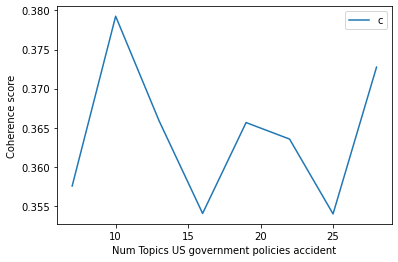

In [35]:
# Show graph for government policies accident for exampe
limit=30; start=7; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_acc)
plt.xlabel("Num Topics US government policies accident")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
coherence_values_twit_pri

[0.22379595374699088,
 0.22379595374699082,
 0.22379595374699082,
 0.22379595374699085,
 0.22379595374699082,
 0.2237959537469908,
 0.22379595374699085,
 0.22379595374699085]

In [37]:
#If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV 
# before flattening out. This is exactly the case here.
# Print the coherence scores

data_name = ['US policies Accident','Foreign policies Accident','US policies Privacy','Foreign policies Privacy',
            'Twitter Privacy', 'Twitter Accident', 'Reddit Privacy','Reddit Accident']

data_cv = [coherence_values_us_acc, coherence_values_fo_acc , coherence_values_us_pri , coherence_values_fo_pri ,
            coherence_values_twit_pri ,  coherence_values_twit_acc, coherence_values_redt_pri, coherence_values_redt_acc]

model_list = [model_list_us_acc, model_list_fo_acc, model_list_us_pri, model_list_fo_pri,
              model_list_twit_pri, model_list_twit_acc, model_list_redt_pri,model_list_redt_acc ]

for name, cv in zip(data_name, data_cv):
    print('coherence val of : '+ name)
    print([round(a, 4) for a in cv])
    #print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

coherence val of : US policies Accident
[0.3576, 0.3793, 0.3659, 0.354, 0.3657, 0.3636, 0.354, 0.3728]
coherence val of : Foreign policies Accident
[0.4164, 0.4529, 0.4282, 0.4064, 0.4316, 0.4404, 0.4418, 0.4597]
coherence val of : US policies Privacy
[0.406, 0.4282, 0.3754, 0.4207, 0.3468, 0.3867, 0.3712, 0.3598]
coherence val of : Foreign policies Privacy
[0.5003, 0.3873, 0.4746, 0.4285, 0.4187, 0.4184, 0.4345, 0.4165]
coherence val of : Twitter Privacy
[0.2238, 0.2238, 0.2238, 0.2238, 0.2238, 0.2238, 0.2238, 0.2238]
coherence val of : Twitter Accident
[0.3681, 0.3361, 0.3386, 0.3347, 0.3398, 0.3633, 0.3559, 0.3707]
coherence val of : Reddit Privacy
[0.3184, 0.2928, 0.2916, 0.2959, 0.2801, 0.2979, 0.2849, 0.2895]
coherence val of : Reddit Accident
[0.3171, 0.2649, 0.2497, 0.278, 0.2527, 0.2928, 0.2786, 0.2829]


In [71]:
print ([e for e in x] )
best_val = [10,10,10,7,7,7,7,7]

# best = [16,7,13,10,7,22,7,7]

best = [1,1,1,0,0,0,0,0]

[7, 10, 13, 16, 19, 22, 25, 28]


ACC /

US :  16
FO :  7
TWI : 22
RED : 7

PRI /
US :  13
FO :  10
TWI : 7
RED : 7


In [19]:
model_list_us_acc

In [39]:
data_name = ['US policies Accident','Foreign policies Accident','US policies Privacy','Foreign policies Privacy',
            'Twitter Privacy', 'Twitter Accident', 'Reddit Privacy','Reddit Accident']


In [72]:
from pprint import pprint
# Select the model and print the topics
optimal_models =[]
for i, model in zip(best, model_list):
    optimal_models.append(model[i])
#optimal_model = model_list[1]

for title, model in zip(data_name, optimal_models):
    model_topics = model.show_topics(formatted=False)
    print('Topics for : '+ title)
    pprint(model.print_topics(num_words=10)[:5])

Topics for : US policies Accident
[(0,
  '0.042*"automate_drive" + 0.020*"dot" + 0.016*"transportation" + '
  '0.013*"performance" + 0.011*"safety_administration" + '
  '0.010*"national_highway" + 0.010*"operation" + 0.010*"guidance" + '
  '0.010*"pdf" + 0.010*"support"'),
 (1,
  '0.047*"scenario" + 0.029*"real" + 0.024*"section" + 0.023*"risk" + '
  '0.021*"define" + 0.021*"automate_drive" + 0.020*"world" + 0.020*"element" + '
  '0.018*"lead" + 0.018*"ad"'),
 (2,
  '0.035*"ad" + 0.028*"entity" + 0.023*"operation" + 0.018*"agency" + '
  '0.017*"hav" + 0.016*"authority" + 0.015*"regulation" + '
  '0.014*"law_enforcement" + 0.013*"operate" + 0.013*"application"'),
 (3,
  '0.033*"liability" + 0.031*"datum" + 0.028*"hav" + 0.023*"insurance" + '
  '0.022*"risk" + 0.014*"owner" + 0.014*"regulation" + 0.013*"industry" + '
  '0.013*"share" + 0.010*"consumer"'),
 (4,
  '0.053*"hav" + 0.023*"whether" + 0.022*"person" + 0.021*"year" + '
  '0.020*"liability" + 0.020*"identify" + 0.020*"must" + 0.0

### What is the Dominant topic and its percentage contribution in each document$
    goal: extract the dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.
    This way, we will know which document belongs predominantly to which topic.

In [73]:
def format_topics_sentences(ldamodel, corpus, texts, cleaned_text):
    #init output
    sent_topics_df = pd.DataFrame()

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        #print (row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        #get the dominant topic, Perc Contribubion and keywords for each document
        for j, (topic_num,prop_topic) in enumerate(row):
            if j==0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # add original text to the end of the output
    contents = pd.Series(texts)
    # cleaned_text = 
    sent_topics_df = pd.concat([sent_topics_df, contents, cleaned_text], axis =1)
    return sent_topics_df


    

In [87]:
# US policies accident
df_topic_sents_keywords = format_topics_sentences(ldamodel= optimal_models[0] , corpus=corpus_us_pol_acc , texts=bigram_us_pol_acc , cleaned_text=df_us_pol_acc.clean_twt_re  )

# format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Document_Topic', 'Topic_Perc_Contrib', 'Keywords','Text', 'Cleaned_Text']

with pd.option_context('display.max_colwidth', None):
    display(df_dominant_topic.head(2))

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Document_Topic,Topic_Perc_Contrib,Keywords,Text,Cleaned_Text
0,0,3,0.6390,"liability, datum, hav, insurance, risk, owner, regulation, industry, share, consumer","[automate_vehicle, onto, horizon, adopt, widespread, use, promote, efficiency, spur, innovation, number, industry, transportation, infrastructure, worldwide, time, high, level, vehi, cle, automation, present, unique, safety, cybersecurity, datum, privacy, issue, manufacturer_supplier, seller, consumer, public, diverse, technological, option, equipment, software, create, market, full, competitor, strive, prove, worth, united_state, federal, government, far, refrain, choose, win, technology, implement, comprehensive, regulatory, regime, many, state, pas, law, address, automate_vehicle, generally, take, permissive, approach, encour, age, development, test, therefore, law, adopt, date, far, uniform, provide, significant, flexibility, company, invest, research, technology, drive, future, highly, automate_vehicle, hav, white, paper, update, technological, regulatory, liability, development, unite, state, since, last, white, ...]",automate vehicle come onto horizon adopt widespread use promote efficiency spur innovation number industry transportation infrastructure worldwide time high level vehi cle automation present unique safety cybersecurity datum privacy issue manufacturer supplier seller consumer public diverse technological option equipment software create market full competitor strive prove worth united state federal government far refrain choose win technology implement comprehensive regulatory regime many state pas law address automate vehicle generally take permissive approach encour age development test therefore law adopt date far uniform provide significant flexibility company invest research technology drive future highly automate vehicle hav white paper update technological regulatory liability development unite state since last white paper november address product liabil ity rule regulation face united state hav manufacturer supplier seller identify legal issue likely arise present absence com prehensive state federal legislation traditional tort liability principle typically govern law professor com mentator wrestle predict future liability rule many expect decrease emphasis common law negligence human driver play less role eventually role operating havs independent function havs put increase emphasis product design cause future accident question product design invoke familiar concept product liability product liability rule likely continue adapt always address unique concern arise within bud hav sector federal preemption could play sub stantial role shape tort liability degree manner remain unresolved federal government yet act define legislation area cyber security data privacy raise special concern manufac turer automate vehicle supplier call federal legislation issue particular without federal intervention manufacturer supplier engage self help contractual risk allocation indem nification agreement limitation warranty consumer edu cation training industry standard insurance white paper aim provide practical advice hav manu facturer supplier seller consider mitigate risk product liability claim background many vehicle roadway already fit auto mate drive feature fully automate vehicle devel opment test type automate transportation drone train ship shuttle bus truck support variety industry already certain retail vendor test use automate drone home delivery online purchase one company begin deliver piz zas robot least one ship company use partially automate truck haul vehiclego across south western united state truck platoone automate taxi bus seem next emerge technology affect even industry directly deploy automate vehicle growth automate transportation eventu ally yield roadway accident growth vehicle share decrease demand traditional parking optimization vehicle function reduce consumption fuel lubricant chemical degradable material wide ra

In [75]:
# dominant topic and percentage distribution in each doc
# Reddit accidents
df_topic_sents_keywords = format_topics_sentences(ldamodel= optimal_models[-1] , corpus=corpus_redt_acc , texts=bigram_redt_acc, cleaned_text=df_redt_acc.clean_twt_re  )

# format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Document_Topic', 'Topic_Perc_Contrib', 'Keywords','Text', 'Cleaned_Text']

with pd.option_context('display.max_colwidth', None):
    display(df_dominant_topic.head(4))
    
    

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Document_Topic,Topic_Perc_Contrib,Keywords,Text,Cleaned_Text
0,0,3,0.4274,"many, need, organ, sdc, people_die, something, kill, good, one, think","[bring, back, train, tram, american, illusion, vehicle, autonomy, kill, city]",bring back train tram american illusion vehicle autonomy kill city
1,1,3,0.6866,"many, need, organ, sdc, people_die, something, kill, good, one, think","[think, control, ultimate, plan, obsolescence, product, electric, automate_vehicle, simple, software, glitch, update, battery, life, fall, want, fix, cost, cost, new, vehicle, buy, new, vehicle, uncle, sam, love, finally, tell, travel, uh, oh, take, part, unapproved, anti, government, protest, freedom, credit, vehicle, long, function, yet, see, single, smart, bit, technology, actually, work, person, always, control, consumption, control, technology, use, free, enslave, always, product, service, something, control, relate, note, somewhat, read, quality, renewable, fuel, like, ethanol, biodiesel, oil, seem, like, big, scam, ever, see, rockefeller, back, temperance, movement, million, wipe, ethanol, industry, big, competition, modern, vehicle, money, sink, need, design, fall, apart, ...]",think control ultimate plan obsolescence product electric automate vehicle simple software glitch update battery life fall want fix cost cost new vehicle buy new vehicle uncle sam love finally tell travel uh oh take part unapproved anti government protest freedom credit vehicle long function yet see single smart bit technology actually work person always control consumption control technology use free go enslave always product service something control relate note somewhat read quality renewable fuel like ethanol biodiesel oil seem like big scam ever see rockefeller back temperance movement million wipe ethanol industry big competition modern vehicle money sink need design fall apart get buy another want simple repairable motor vehicle run homemade ethanol something fix even need fast could would go mph top
2,2,3,0.8690,"many, need, organ, sdc, people_die, something, kill, good, one, think","[catch, transit, actually, suck, vehicle, around, everyone, vehicle, around, mean, everything, sprawl, transit, incredibly, inefficient, expensive, passenger, mile, planner, smart, use, fee, subsidy, lever, push, sdc, feed, people, transit, line, transit, line, high, frequency, mean, well, performance]",catch transit actually suck vehicle get around everyone vehicle get around mean everything sprawl make transit incredibly inefficient expensive per passenger mile planner smart would use fee subsidy lever push sdc feed people transit line transit line high frequency mean well performance
3,3,5,0.9463,"die, rate, think, well, gm, might, live, light, owner, know","[think, normal, decade, simply, lucrative, happen, quite, literally, gas, station, put, ad, gas, pump, captive, audience, even, captive, audience, well, yet, one, dependent, device]",think go normal decade simply lucrative happen quite literally gas station put ad gas pump captive audience even captive audience well yet one dependent device get go


In [79]:
# with pd.option_context('display.max_colwidth', None):
#    display(df_dominant_topic[['Document_Topic','Keywords','Cleaned_Text']].head(4))

In [82]:
# let's do only for the Social Media platforms
data_name = ['US policies Accident','Foreign policies Accident','US policies Privacy','Foreign policies Privacy',
            'Twitter Privacy', 'Twitter Accident', 'Reddit Privacy','Reddit Accident']
target= [4,5,6,7]

8

In [67]:
# all_clean_txt[8]

In [122]:
# dominant topic and the percentage distribution of each topic in each document

for index in target:
    if index == 6 or index ==7:
        df_topic_sents_keywords = format_topics_sentences(ldamodel= optimal_models[index] , corpus=all_corpus[index] , texts=all_bigrams[index], cleaned_text=all_clean_txt[index].comment  )
    else:
        df_topic_sents_keywords = format_topics_sentences(ldamodel= optimal_models[index] , corpus=all_corpus[index] , texts=all_bigrams[index], cleaned_text=all_clean_txt[index].clean_twt_re  )
    
    # format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Document_Topic', 'Topic_Perc_Contrib', 'Keywords','Text', 'Comment']
    print(data_name[index])
    with pd.option_context('display.max_colwidth', None):
        print("dominant topic and the percentage distribution of each topic in each document")
        # print/ display the dfs
        # display(df_dominant_topic[['Document_Topic','Keywords','Comment']].head(3))

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Twitter Privacy
dominant topic and the percentage distribution of each topic in each document


/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Twitter Accident
dominant topic and the percentage distribution of each topic in each document


/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Reddit Privacy
dominant topic and the percentage distribution of each topic in each document


/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Reddit Accident
dominant topic and the percentage distribution of each topic in each document


In [83]:
# df_dominant_topic.sort_values('Document_Topic')
# df.sort_values(by=['col1'])

### The most representative sentence for each topic
get samples of sentences that most represent a given topic. This code gets sample of sentences for each topic.


In [141]:
### twitter and reddit
# Display setting to show more characters in column
#pd.options.display.max_colwidth = 100

for index in target:
    if index == 6 or index ==7:
        df_topic_sents_keywords = format_topics_sentences(ldamodel= optimal_models[index] , corpus=all_corpus[index] , texts=all_bigrams[index], cleaned_text=all_clean_txt[index].comment  )
    else:
        df_topic_sents_keywords = format_topics_sentences(ldamodel= optimal_models[index] , corpus=all_corpus[index] , texts=all_bigrams[index], cleaned_text=all_clean_txt[index].tweet.reset_index(drop=True)  )
    
    sent_topics_sorteddf_mallet = pd.DataFrame()
    sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

    
    for i, grp in sent_topics_outdf_grpd:
        sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                                 grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                                axis=0)

    # Reset Index    
    sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

    # Format
    sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Topic_Keywords", "Representative Text", "Comment"]

    print(data_name[index])
    with pd.option_context('display.max_colwidth', None):
        display(sent_topics_sorteddf_mallet[['Topic_Num','Topic_Perc_Contrib','Topic_Keywords','Comment']] .head(3))
        


/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Twitter Privacy


,Topic_Num,Topic_Perc_Contrib,Topic_Keywords,Comment
0,0,0.9046,"full, automate, tesla, vehicle, driver, right, datum, private, think, drive",based electric vehicle manufacturer tesla sued violating biometric privacy rights alleged tesla scanning drivers faces vehicles part autopilot full selfdriving systems image
1,1,0.7142,"concern, need, automate, protection, think, datum, vehicle, private, full, law",safety security privacy real metrics needing met ai autonomous vehicles smart worlds concerns real proven met much power going allow
2,2,0.7856,"private, drive, right, need, think, automate, datum, use, vehicle, full",homeschooling self employment alternative lifestyle british herstory marcus garvey interracial relationships real hair black woman shea butter boris johnson private education private schooling driving across britain love art geography police uk shrines


/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Twitter Accident


,Topic_Num,Topic_Perc_Contrib,Topic_Keywords,Comment
0,0,0.8772,"company, link, law, new_york, responsible, liability, happen, course, might, technology",weird way spell self driving cars crash shit time strange way spell plastic cars way less protection case crash
1,1,0.9340,"accident, tesla, human, cause, driver, one, safe, use, even, drive",didnt understand said self driving car much safer human doesnt mean wont accidents means would fewer accidents tesla advises drivers use self driving stay drivers seat aware surroundings
2,2,0.9142,"accident, road, many, well, firstever, driver, tech, right, like, software",aibattery tech convergence disrupt transportation creating new possibilities ie flying vehicles autonomous vehicles etc autonomous vehicles could save lives reducing total number fatal accidents


/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Reddit Privacy


,Topic_Num,Topic_Perc_Contrib,Topic_Keywords,Comment
0,0,0.9521,"privacy, people, say, company, want, mean, really, work, way, know",the problem ive always seen is that i think most or possibly all due to legal requirements privately owned early sdcs are likely to have a manual drive mode i find it unlikely automakers are going to insure people driving themselves that would mean if the makers insure the autonomous driving then you have to have two separate insurance policies and that just seems undesirable but at the end of the day i really do think we spend way too much time discussing this issue the cars will be insured one way or another the end user is going to be paying for it at the end of the day if the manufacturers are going to be the actual provider of the insurance great i guess but its one of the least interesting issues to talk about imo
1,1,0.9681,"beta, public, road, use, automate, mean, test, tesla, like, driver",such that no one was ever injuredkilled probably very few incidents happen but that doesnt mean products like space heaters washing machines train engines and whatnot werent initially tested as much as possible inside a lab before deploying them on a large scale im not arguing vs having a couple of beta testers on the roads with safety glasses on here im arguing regular consumers shouldnt be enrolled in self driving software betas without being employed in some way by the company to do so and having done some specific safety training like if this was the new call of duty beta on the road want to test these cars hire some damn qa people to do so in simulations then in private roads and then on public roads and keep doing that until you dont consider that a beta at all at that point some incidents may yet happen and that is okay no tech is perfect
2,2,0.9427,"still, need, take, think, also, away, actually, time, say, work",thanks for the informed question i am hopeful i think we can and should build a framework to evaluate the inputs the models and the outputs there are statistical criteria one uses in say regression models to assess how good a model is they need to be extended to include tests for things such as bias in the inputs outputs gender race etc implications for privacy security etc procedurally i also think that algorithms deployed in socially significant settings should be audiedvalidated by a team other than the team that developed the model such a team can be within the org or a rd party but such procedures will also help you may also find the area of fairness accountability transparency in ml fatml interesting


/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Reddit Accident


,Topic_Num,Topic_Perc_Contrib,Topic_Keywords,Comment
0,0,0.9834,"fault, avoid, hit, blame, pedestrian, crash, brake, system, uber, tech",the following is a copy of the original post to record the post as it was originally written imagine a world where autonomous vehicles self driving cars become commonplace and overwhelmingly prove to be vastly superior to non autonomous vehicles regular cars a world where car accidents and car deaths are unheard of a world where pedestrians being hit by self driving cars is unheard of lets say we achieve this future where self driving cars are a significant portion of the cars out there and nobody on the planet can deny their efficacy and vast superiority over human drivers would you support banning non autonomous vehicles or would there be an element of individual freedom that outweighs the lives lost i am a bot and this action was performed automatically please contact the moderators of this subredditmessagecompose toraskaliberal if you have any questions or concerns
1,1,0.9852,"autopilot, crash, insurance, company, datum, safe, like, risk, test, use",yes if the cars are sharing data then cars could react to things they cant yet sense going around a corner a lead car or a car coming from another direction could detect an animal in the road and tell the cars behind it to slow down maybe there are changing road conditions like a puddle mudslide ice etc this would not only make other self driving cars safer but it would potentially give human drivers more time to react leading to fewer secondary accidents pileups also as of last year googles car used lidar for small details which has problems in the rain snow so a car might not be able to accurately sense the road conditions until the traction control system tells the car about it which doesnt happen until the tires actually drive over the surface synced cars would make them all safer by giving them more data to base their decisions on
2,2,0.9780,"tesla, crash, mile, waymo, safe, death, year, one, drive, statistic",i dont think it would be acceptable to ban one form of transport for safety reasons for another that was not safe in addition if its between someone being able to get around or not because they dont trust the technology then they should be able to drive themselves comfort has always outweighed lives saved approximately million people are killed in fatal crashes each year on average thats about deaths a day globally an additional million are injured or accident statistics no one has banned cars yet


In [ ]:
# Show
# with pd.option_context('display.max_colwidth', None):
#    display(sent_topics_sorteddf_mallet.head(3))

# sent_topics_sorteddf_mallet.head(10)

In [163]:
target2 = [0,1,2,3]

In [164]:
#all_clean_txt[1]['full text']

In [166]:
### US and foreign policies

# Display setting to show more characters in column
#pd.options.display.max_colwidth = 100

for index in target2:
    if index == 0 or index ==2:
        df_topic_sents_keywords_ = format_topics_sentences(ldamodel= optimal_models[index] , corpus=all_corpus[index] , texts=all_bigrams[index], cleaned_text=all_clean_txt[index].policies  )
    else:
        df_topic_sents_keywords_ = format_topics_sentences(ldamodel= optimal_models[index] , corpus=all_corpus[index] , texts=all_bigrams[index], cleaned_text=all_clean_txt[index]['full text'].reset_index(drop=True)  )
    
    sent_topics_sorteddf_mallet_ = pd.DataFrame()
    sent_topics_outdf_grpd_ = df_topic_sents_keywords_.groupby('Dominant_Topic')

    
    for i, grp in sent_topics_outdf_grpd_:
        sent_topics_sorteddf_mallet_ = pd.concat([sent_topics_sorteddf_mallet_, 
                                                 grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                                axis=0)

    # Reset Index    
    sent_topics_sorteddf_mallet_.reset_index(drop=True, inplace=True)

    # Format
    sent_topics_sorteddf_mallet_.columns = ['Topic_Num', "Topic_Perc_Contrib", "Topic_Keywords", "Representative Text", "Comment"]

    print(data_name[index])
    with pd.option_context('display.max_colwidth', None):
        display(sent_topics_sorteddf_mallet_[['Topic_Num','Topic_Perc_Contrib','Topic_Keywords','Comment']] .head(3))
        


/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


US policies Accident


,Topic_Num,Topic_Perc_Contrib,Topic_Keywords,Comment
0,0,0.9917,"automate_drive, dot, transportation, performance, safety_administration, national_highway, operation, guidance, pdf, support",introduction motivation automated driving one key modern technologies addition offering broader access mobility help reduce number driving related accidents crashes safety automated driving vehicles one important factors designed supplement existing publications various aspects safety publication presents technical based overview requirements development avoid safety related hazards thus emphasizing importance safety design furthermore publication aims provide sound discussion verification validation systems currently still missing existing literature publication intended contribute current activities working towards industry wide standardization automated driving effort contribute toward deeper understanding developing framework guideline safety automated driving systems companies automotive mobility world technology startups established oems tiered suppliers key technologies scope publication goal publication provide overview guidance generic steps developing validating safe automated driving system starting point defining guidelines principles taken different regulatory publications various legal frameworks around world ethics reports etc principles foundation publication forming basis safety design methods strategies derived constant focus hereby development required addition existing sae driver assistance systems important consider security conjunction safety security concerned active adversaries whereas safety deals passive adversaries difference warrants use additional analysis tools technical mechanisms turn impact safety thus safety security work together section explores concept greater detail publication aims develop guidance tackle risks introduced automated vehicles approach comprises common consensus contributing companies must expanded upon every specific system introduced onto market publication written based state art automated driving technology time publication complete work contents continuously revisited revised whenever advances made areas social acceptance technology legislation
1,1,0.9915,"scenario, real, section, risk, define, automate_drive, world, element, lead, ad",process consideration changing environment new types vehicles new traffic signs new roads etc within overall validation homologation time span homologation body represented technical service team oem jointly define kinds tests relevant fulfilling framework homologation quantity quality testing discussed section one key challenges validating automated driving systems statistically demonstrate positive risk balance section defines main safety objective demonstrated purely statistical black box approach would require using automated driving system customer would automated vehicles would driven hundreds millions miles sometimes hundreds billions miles demonstrate reliability terms fatalities injuries kalra paddock due rarity failure events real world test driving alone cannot provide high confidence safety automated driving systems respect injuries fatalities wachenfeld salay czarnecki address challenge test strategy proposed section combines statistical testing real world driving one approaches stated defining equivalence classes scenarios see details defining surrogate metrics leading measures crashes path collision track system safety especially regression tests fraade blanar blumenthal anderson kalra surrogate metrics leading measures concepts stated rand report different equivalence classes categorize scenarios controllability exposure severity leading measures performance indicators suggest hazardous condition one example might infractions traffic road rules necessarily potential cause collision injury lead harmful scenario vulnerable road users present leading measures could allow better assessment system performance allow fine grained comparison h

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Foreign policies Accident


,Topic_Num,Topic_Perc_Contrib,Topic_Keywords,Comment
0,0,0.9907,"moral, cavs, pedestrian, infrastructure, communication, future, gap, cav, obtain, different",customer focused successful places strong economy safety performance accessible services sustainability future transport nsw customer focused successful places future transport nsw customer focused support wider range ﬂexible aﬀordable journey options customers provide richer information successful places enhance connections people places enable liveable cities reducing need parking strong economy improve eﬃcient movement freight allow people use travel time productively support economic growth nsw sustainable reduce fuel consumption emissions make public transport cheaper run save taxpayers money accessible services enhance access public transport improve mobility social inclusion people cannot drive safety performance help traﬃc roads ﬂow smoothly prevent crashes involving human error customer focused successful places strong economy safety performance accessible services sustainability future transport nsw successful places strong economy future transport nsw customer focused successful places strong economy customer focused successful places safety performance accessible services figure cavs deliver six key outcomes future transport adapted cavs connected automated vehicles plan executive summary
1,1,0.9112,"framework, regulatory, panel, fy, policy, map, begin, february, industry, paper",paper purpose paper purpose paper present end end regulatory framework commercial deployment automated vehicles australia national transport commission ntc leading work regulatory framework automated vehicles course close consultation government industry broader public framework presented paper consists existing regulatory frameworks new regulatory frameworks agreed infrastructure transport ministers recent ministers decisions made february detail service framework included presenting existing new frameworks together provides clear picture regulatory landscape govern automated vehicles deployment begins australia legislation implement new frameworks still however need drafted passed parliaments paper represents culmination work ntc governments industry develop end end regulatory framework automated vehicles particular safety assurance framework background australia laws currently support deployment automated vehicles laws designed vehicles human drivers review found barriers deployment automated vehicles state territory commonwealth laws automated vehicles expected deliver safety productivity mobility environmental benefits without reforms australians able gain benefits infrastructure transport ministers agreed development end end regulatory framework commercial deployment automated vehicles since ntc working government industry develop framework work led ministers decisions regulated parties determining control automated vehicle safety assurance automated vehicles first supply new national law new regulator service safety automated vehicles approach motor accident injury insurance maii automated vehicles regulating government access automated vehicle data ministers agreed roadmap implementing national safety framework automated vehicles included set principles end end framework framework nationally consistent support single national market vehicles australia internationally aligned maintain alignment evolving international standards keep australia part global vehicle market
2,2,0.9936,"collision, increase, case_vehicle, could, infrastructure, rate, benefit, industry, challenge, manufacturer",choosing canada automotive future road safety number collisions canada resulting injuries fatalities dropped respectively tc however motor vehicle collisions still caused fatalities serious injuries canada tc collisions causing injuries fatal collisions occur rural roads occur mainly undivided roads often associated high speeds alcohol use non use seatbelts tc although case vehicles could help im

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


US policies Privacy


,Topic_Num,Topic_Perc_Contrib,Topic_Keywords,Comment
0,0,0.9914,"automate_drive, section, act, drive, bill, follow, relevant, occupant, practice, traffic",vehicle networks today require high bandwidth low latency reliable light weight paper identifies two alliances working addressing subject avnu avnu alliance comprises ethernet technology developers silicon suppliers work together low latency time synchronized highly reliable communication network solutions prominent examples work audio video bridging avb time synchronized networking tsn standards enable classic ethernet networks achieve low latency target goals time synchronization high reliability nav networking autonomous vehicles nav alliance aims establishing vehicle network platform meets needs highly future automated driving systems alliance focuses developing specification high speed vehicle networks improve interoperability security reliability promoting best practices solutions compatible specifications members alliance comprise oems tier one suppliers mapping technology developers vehicle networks public adoption autonomous vehicles crucial acceptance widespread use two initiatives identified study pave people autonomous vehicles urban environments pave coalition gathers industry non profit groups enhance public policy makers understanding autonomous vehicle technology intention educational advocate specific technology public policies pave achieves providing educational website social media channels hands demonstrations driverless vehicles organizing relevant conferences public forums engage public informing policy makers real facts self driving technologies help make informed decisions clepa clepa brings together global suppliers automobile sector national trade associations european sector associations sake closer alignment diverse set regulatory matters association aims tackle challenges varying reaching consensus international adoption legal framework road safety testing vehicles traffic regulations driver training data processing regulations control management collected road data data privacy etc relevant technical standards liability matters public awareness regulation collaborations described past sections examples groups bodies established tackle particular challenges automotive industry automated driving domains organizations consolidate efforts building platform collaboration relevant automotive ecosystem actors two examples collaboration platforms open autodrive forum open autodrive forum objective generating globally applicable state art solutions automated driving ultimately used input standardization bodies open autodrive forum includes local authorities discussions closer alignment regulatory matters one focal points forum participants reference ecosystem architecture automated driving includes definition building blocks automated vehicle sensors environmental model localization etc road infrastructure digital maps data collection centres etc collaboration platforms autonomous vehicle governance ecosystem guide decision makers
1,1,0.9931,"program, michigan, management, transportation_system, mobility, investment, infrastructure, impact, private, connect",part actions council policy recommendations strategic site development fund million way scaling supplementing medc build ready site program based medc estimates level funding could develop six large sites acres larger additional smaller sites less populated areas state funding allow smaller medium sized businesses expand companies position operations recover impacts pandemic prepare new industry technology demands projected outcomes acreage development billion private investment new jobs created million public private match funds grants fund awarded applications prioritize impact geographically disadvantaged areas distressed communities demonstrate site development lead substantial number pathway job opportunities equitable high wage growth opportunities individuals benefit target industry sectors ev

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1764087036.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Foreign policies Privacy


,Topic_Num,Topic_Perc_Contrib,Topic_Keywords,Comment
0,0,0.9718,"transport, time, travel, cost, share, uber, vehicleshare, report, people, mobility",licea ruby harshbarger uber cars yellow taxis road nyc new york post new york accessed march nypost com uber cars yellow taxis road nyc linden fenn understanding gartner hype cycles gartner research strategic analysis report accessed september bus umich edu kresgepublic journals gartner research pdf litman autonomous vehicle implementation predictions implications transport planning victoria canada victoria transport policy institute accessed april vtpi org avip pdf mahajan muller bass diffusion new products empirical generalizations managerial uses marketing science martin shaheen lidicker impact carsharing household vehicle holdings results north american shared use vehicle survey transportation research record journal transportation research board merat madigan nordhoff human factors user requirements user acceptance ride sharing automated vehicles international transport forum discussion paper paris france accessed march search proquest com ezproxy waikato ac nz docview fulltextpdf cbcpq accountid ministry transport driver travel new zealand household travel survey wellington new zealand author accessed february transport govt nz assets uploads research documents bdbb drivers pdf ministry transport comparing travel modes new zealand household travel survey wellington new zealand author accessed february transport govt nz assets uploads research documents bcded comparing travel modes pdf ministry transport annual fleet statistics wellington new zealand author ministry transport monthly electric hybrid light vehicle registrations accessed january transport govt nz research newzealandvehiclefleetstatistics mishra gs rr clewlow pl mokhtarian kf widaman effect carsharing vehicle holdings travel behavior propensity score causal mediation analysis san francisco bay area research transportation economics momo car sharing reduces burden cities environment environmental impacts car sharing use car sharing fact sheet accessed january ec europa eu energy intelligent projects sites iee projects files projects documents momo_car sharing_f_environmental_impacts_en pdf moore ga crossing chasm marketing selling high tech products mainstream customers new york harper neoh jg chipulu marshall encourages people carpool evaluation factors meta analysis transportation
1,1,0.9755,"cavs, cav, user, respondent, concern, personal_datum, recommendation, right, individual, develop",recommendation traffic rules identify contexts appropriate actions situations cavs contravene traffic rules study ability cav systems balance norms principles decision making explainability thereof recommendation inequalities identify road user groups incur disproportionate harm exposure ratio develop deploy cavs reduce strong disparities harm exposure ratio study ethical social acceptability measures recommendation dilemmas explore acceptability cav behaviour dilemmas based adherence principles risk distribution engage public inclusive process cav behaviour dilemmas encourage data sharing cav behaviour dilemma situations recommendation privacy informed consent seek informed consent cav data collection facilitate data subjects control data prevent unauthorised access technical infrastructure associated data enforce enhance data protection legislation protect cav user data recommendation user choice develop agile consent based user agreements cav based services leverage competition consumer law counteract monopolies enable user choice cav services develop industry standards around algorithmic inference addressing ethical data sharing transparency business practices protecting informational privacy informed consent recommendation individual privacy group level develop ethical legal guidelines protect individuals rights group level primary target group manufacturers deployerspolicymakersresearchers
2,2,0.9952,"ad, adse, state_ter

In [147]:
## pyLDAVis
import pyLDAvis.gensim_models
from IPython.core.display import display,HTML
pyLDAvis.enable_notebook()

for index in target:  
    vis = pyLDAvis.gensim_models.prepare(optimal_models[index], all_corpus[index] , dictionary=all_id2word[index] , mds = 'pcoa', sort_topics=True)
    # pyLDAvis.display(vis)

    #vis = pyLDAvis.gensim_models.prepare(lda_topic_model, corpus, dictionary=lda_topic_model.id2word) 
    filename = 'pyVis/' + data_name[index]+'.html'
    pyLDAvis.save_html(vis, filename) #'gensim_lda_result.html')

    # then display the HTML output using IPython.core.display:

    # to display, but we won't
    # display(HTML(filename))
    
    

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/1101733457.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display,HTML
/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp im

In [149]:
filename

'pyVis/Reddit Accident.html'

In [167]:
# for policies

## pyLDAVis
import pyLDAvis.gensim_models
from IPython.core.display import display,HTML
pyLDAvis.enable_notebook()

for index in target2:  
    vis = pyLDAvis.gensim_models.prepare(optimal_models[index], all_corpus[index] , dictionary=all_id2word[index] , mds = 'pcoa', sort_topics=True)
    # pyLDAvis.display(vis)

    #vis = pyLDAvis.gensim_models.prepare(lda_topic_model, corpus, dictionary=lda_topic_model.id2word) 
    filename = 'pyVis/' + data_name[index]+'.html'
    pyLDAvis.save_html(vis, filename) #'gensim_lda_result.html')

    # then display the HTML output using IPython.core.display:

    # to display, but we won't
    # display(HTML(filename))


/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_23502/2587080689.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display,HTML
/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp im

In [ ]:
print("\nTopics for twitter")
components_twi,feat_names_twi,lda_matrix_twi = lda_pipeline_(df_sec_twit,10,0.5,0)
print_top_words_for_topic(components_twi[:10], feat_names_twi, 10)

In [ ]:
import logging
import warnings
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus4_twit,
                           num_topics=5,
                           id2word=train_id2word_twit,
                           random_state=100,
                           chunksize=10,
                           workers=7, # Num. Processing Cores - 1
                           passes=10,
                           eval_every = 1,
                           iterations=100,
                           per_word_topics=True)
    lda_train4.save('lda_train4.model')

In [ ]:
Sourceqs:
    
    https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
        